In [1]:
from __future__ import annotations
import numpy as np
from typing import *
import copy
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
import benchmark_functions as bf
from timeit import default_timer as timer
import math

In [2]:
class MetricCollector:
    def __init__(self, name: str = None, run_id: int = None):
        self.best_individual_cost_each_gen = []
        self.avg_cost_each_gen = []
        self.name = name
        self.run_id = run_id
        self.iter_reached_vtr = -1
        self.nfev = -1
        self.time = -1

    def collect_once(self, best_individual_fitness: float, avg_fitness: float):
        self.best_individual_cost_each_gen.append(best_individual_fitness)
        self.avg_cost_each_gen.append(avg_fitness)

    def collect_vtr(self, i, nfev, time):
        self.iter_reached_vtr = i
        self.nfev = nfev
        self.time = time


    def compile_graph(self):
        xs = np.arange(len(self.best_individual_cost_each_gen))
        plt.scatter(xs, self.best_individual_cost_each_gen, label="Best Individual Fitness", marker="x", s=1)
        plt.scatter(xs, self.avg_cost_each_gen, label="Average Fitness", marker=".", s=1)
        plt.yscale("log")
        plt.legend()

        path = f"results/ge/{self.name}/"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(f"{path}cost.npy", self.best_individual_cost_each_gen)
        plt.savefig(f"{path}graph.png")

    def save_results(self):
        path = f"results/ge/{self.name}/{self.run_id}.txt"

        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            f.write(f"{self.best_individual_cost_each_gen[-1]}\n")
            f.write(f"{self.iter_reached_vtr}\n")
            f.write(f"{self.nfev}\n")
            f.write(f"{self.time}\n")

In [3]:
def bound_applier(
    x: np.ndarray,
    bounds: List[Tuple]
):
    bounded = np.zeros_like(x)
    for i in range(len(x)):
        bounded[i] = x[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    return bounded

def latin_hyper_cube_initializer(dimension: int, population_size: int, bounds: List[Tuple], seed: int = 0) -> np.ndarray:
    lsh_sampler = stats.qmc.LatinHypercube(d=dimension, seed=seed)
    sample = lsh_sampler.random(n=population_size)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample,
        dtype=np.float128
    )
    return bounded

def check_bounds(
    x: np.ndarray,
    bounds: List[Tuple]
):
    x_copy = copy.deepcopy(x)
    for i in range(len(x)):
        if x_copy[i] < bounds[i][0]:
            x_copy[i] = bounds[i][0]
        elif x_copy[i] > bounds[i][1]:
            x_copy[i] = bounds[i][1]
    return x_copy

def latin(sampler, n: int, bounds: List[Tuple]):
    sample = sampler.random(n=n)
    bounded = np.apply_along_axis(
        lambda x: bound_applier(x, bounds),
        1,
        sample
    )
    return bounded

In [12]:
def gradient_evolution(
    f: Callable,
    pop_initializer: Callable[[int], np.ndarray],
    popsize: int,
    n_iter: int,
    gamma: Callable[[int], float],
    J: float,
    S: float,
    ep: float,
    bounds: List[Tuple],
    metric_collector: MetricCollector,
    vtr: float = 1e-8,
):
    nfev = 0

    def f_stub(x):
        nonlocal nfev
        nfev += 1
        return f(x)

    population = pop_initializer(popsize)
    population_val = np.apply_along_axis(f_stub, 1, population)
    history = np.array([1. for i in range(popsize)], dtype=np.float64)

    best_ind = np.argmin(population_val)
    worst_ind = np.argmax(population_val)

    best_so_far = population[best_ind]
    best_so_far_val = population_val[best_ind]
    collected_vtr = False
    start = timer()

    for i in range(n_iter):

        if i % 100 == 0:
            print(f"iter: {i}, best: {best_so_far_val}, avg: {np.mean(population_val)}")

        for j in range(popsize):

            if abs(population_val[j] - population_val[best_ind]) < 1e-16:
                rand_k = np.random.randint(0, popsize)

                while rand_k == j:
                    rand_k = np.random.randint(0, popsize)

                delta_x = (gamma(i) + np.abs(population[rand_k] - population[j])) / 2
                b = population[j] - delta_x
                numer = population[rand_k] - b
                denom = population[rand_k] - 2 * population[j] + b
                newton_approx = numer / (denom + 1e-16)
                trial = population[j] \
                               - (np.random.normal() * delta_x / 2) * newton_approx \
                               + np.random.normal() * (population[best_ind] - population[j])

            elif abs(population_val[j] - population_val[worst_ind]) < 1e-16:
                rand_k = np.random.randint(0, popsize)

                while rand_k == j:
                    rand_k = np.random.randint(0, popsize)

                delta_x = (np.abs(population[j] - population[rand_k]) + gamma(i)) / 2
                w = population[j] + delta_x
                numer = w - population[rand_k]
                denom = w - 2 * population[j] + population[rand_k]
                newton_approx = numer / (denom + 1e-16)
                trial = population[j] \
                               - (np.random.normal() * delta_x / 2) * newton_approx \
                               + np.random.normal() * (population[best_ind] - population[j])

            else:
                all_better = np.where(population_val < population_val[j])[0]
                all_worse = np.where(population_val > population_val[j])[0]
                better = all_better[np.random.choice(all_better.shape[0])]
                worse = all_worse[np.random.choice(all_worse.shape[0])]
                delta_x = (np.abs(population[j] - population[better]) + np.abs(population[worse] - population[j])) / 2
                numer = population[worse] - population[better]
                denom = population[worse] - 2 * population[j] + population[better]
                newton_approx = numer / (denom + 1e-16)
                trial = population[j] \
                               - (np.random.normal() * delta_x / 2) * newton_approx \
                               + np.random.normal() * (population[best_ind] - population[j])

            r_j = np.random.normal()
            if r_j < J:
                rand_k = np.random.randint(0, popsize)
                while rand_k == j:
                    rand_k = np.random.randint(0, popsize)
                trial = -trial + np.random.normal() * (trial - population[rand_k])

            trial = check_bounds(trial, bounds)

            fitness = f_stub(trial)

            if fitness < population_val[j]:
                population[j] = trial
                population_val[j] = fitness
                history[j] = 1
            else:
                history[j] = history[j] - ep * history[j]

            if history[j] <= S:
                population[j] = pop_initializer(1)
                population_val[j] = f_stub(population[j])
                history[j] = 1

            best_ind = np.argmin(population_val)
            worst_ind = np.argmax(population_val)

        if population_val[best_ind] < best_so_far_val:
            best_so_far = population[best_ind]
            best_so_far_val = population_val[best_ind]

        metric_collector.collect_once(best_so_far_val, np.mean(population_val))

        if population_val[best_ind] < vtr and not collected_vtr:
            end = timer()
            metric_collector.time = end - start
            metric_collector.collect_vtr(i, nfev, end - start)
            collected_vtr = True

    if not collected_vtr:
        end = timer()
        metric_collector.time = end - start
        metric_collector.collect_vtr(n_iter, nfev, end - start)

    return best_so_far, best_so_far_val

iter: 0, best: 65660.2504606203, avg: 100142.66531291403
iter: 100, best: 0.0023930721226917326, avg: 0.2033599210818608
iter: 200, best: 6.538960207898613e-10, avg: 1.3725358552542254e-06
iter: 300, best: 4.9180747052366865e-15, avg: 3.1422239276766856e-06
iter: 400, best: 3.3673249428638413e-17, avg: 11141.126515921434
iter: 500, best: 3.3673249428638413e-17, avg: 7.731513913496877e-05
iter: 600, best: 3.3673249428638413e-17, avg: 230.3365095817384
iter: 700, best: 3.3673249428638413e-17, avg: 4.901821749042427e-08
iter: 800, best: 2.0842908970099558e-17, avg: 1.0316751632813261
iter: 900, best: 2.0842908970099558e-17, avg: 1.5340607078957913e-06
iter: 0, best: 60455.89344133916, avg: 99908.41956111662
iter: 100, best: 0.0042014148811609, avg: 0.08288263293157548
iter: 200, best: 2.070966366332458e-09, avg: 0.00012843215286419645
iter: 300, best: 3.562374864033808e-14, avg: 0.15610733439409152
iter: 400, best: 2.4975878659546235e-17, avg: 0.21504681426987657
iter: 500, best: 1.858754

(array([ 9.49540215e-04, -1.81216210e-03, -1.69671903e-04,  6.57412527e-04,
        -4.24119000e-04,  1.07440472e-03,  3.73790996e-05, -4.61080416e-04,
        -5.18846661e-04,  1.62410510e-04, -1.27849135e-04, -3.23500277e-04,
         9.92132506e-04,  2.49027306e-04,  5.69005280e-04,  2.43516420e-03,
         1.35695007e-03,  1.67633857e-03, -5.11169192e-04, -2.40513972e-04,
         1.25817649e-04,  3.08147546e-04,  1.63004629e-03,  3.82454570e-04,
         1.51993087e-03, -1.64498678e-02, -6.92002411e-05, -5.51056329e-04,
         2.27213955e-03,  1.93205962e-03]),
 1.34722991576142e-17)

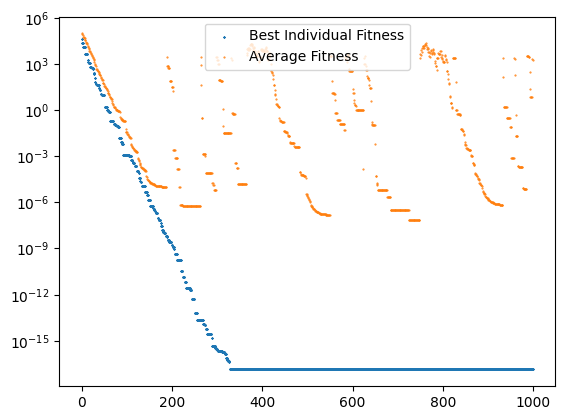

In [15]:
def sphere(x: np.ndarray):
    return np.sum(np.apply_along_axis(lambda y: (y)**2, 0, x))

for i in range(30):
    np.random.seed(i)
    metric_sphere = MetricCollector(name="sphere", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.1 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)

    res = gradient_evolution(
        f=sphere,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_sphere,
    )
    metric_sphere.save_results()

metric_sphere.compile_graph()
res # 88686.32297117583 88686.32297117583

iter: 0, best: 968576.1644013957, avg: 1597788.901189229
iter: 100, best: 6278.406635720777, avg: 43235.55964562601
iter: 200, best: 1197.3315288686267, avg: 1933.3081173867442
iter: 300, best: 361.7809828465779, avg: 6232.4842443407415
iter: 400, best: 121.65575704453089, avg: 9703.923935737937
iter: 500, best: 57.277658581253874, avg: 65290.106052652365
iter: 600, best: 31.47992810559895, avg: 44971.81145684701
iter: 700, best: 16.764141929639916, avg: 103674.90245263977
iter: 800, best: 5.708728736449685, avg: 45725.06715637636
iter: 900, best: 4.885301395671843, avg: 85695.35074888673
iter: 0, best: 981329.930586205, avg: 1593781.73029887
iter: 100, best: 3551.806611630148, avg: 46058.7834732289
iter: 200, best: 872.384149106934, avg: 62497.156510457
iter: 300, best: 262.2878948859915, avg: 61944.141139476305
iter: 400, best: 95.24508801334734, avg: 49452.184008066266
iter: 500, best: 42.543000675233735, avg: 107550.40486636323
iter: 600, best: 21.952885016337614, avg: 29536.948621

(array([10.01872797, 10.66616404,  9.75762645,  9.67233775,  9.68091   ,
        10.40518419, 10.10071305,  9.87596319, 10.28507576, 10.04069477,
         9.70934268,  9.90029898,  9.81579271,  9.92382894, 10.12441177,
         9.93656701, 10.10871995, 10.03290284, 10.04259226,  9.80156193,
        10.08218577,  9.94432015, 10.10594241, 10.01797511, 10.08238609,
        10.10107236, 10.12530557,  9.97286607,  9.84390648,  9.92271799]),
 9.08127836801696)

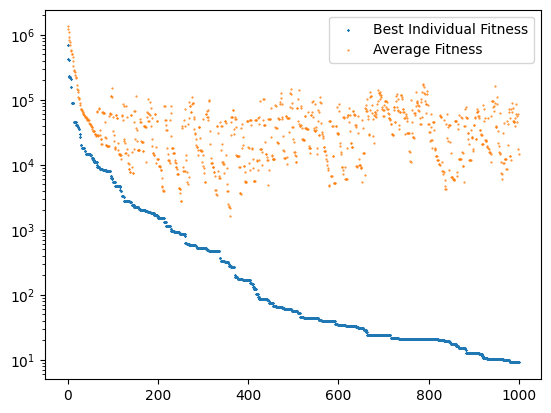

In [16]:
def weighted_sphere(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += (i + 1) * (x[i] - 10) ** 2
    return cost

for i in range(30):
    np.random.seed(i)
    metric_weighted_sphere = MetricCollector(name="weighted_sphere", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.8 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=weighted_sphere,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_weighted_sphere,
    )
    metric_weighted_sphere.save_results()

metric_weighted_sphere.compile_graph()
res

iter: 0, best: 116160.19496729347, avg: 2234606.6566458084
iter: 100, best: 18624.13163581871, avg: 124910.44399080626
iter: 200, best: 3946.823764081738, avg: 82533.1128960361
iter: 300, best: 1336.3422239745646, avg: 217265.12708959245
iter: 400, best: 1126.8033033063186, avg: 52581.86306564751
iter: 500, best: 902.5888273900864, avg: 95203.85517308908
iter: 600, best: 483.1212921729179, avg: 71490.27236711225
iter: 700, best: 430.47512358598766, avg: 37353.59752116624
iter: 800, best: 374.0513241039625, avg: 76934.1631013647
iter: 900, best: 363.56633174379573, avg: 118379.3960033375
iter: 0, best: 101131.53102364889, avg: 2390588.8695615395
iter: 100, best: 8712.60911253036, avg: 269314.2599795099
iter: 200, best: 7864.442429044107, avg: 94057.54651507377
iter: 300, best: 4378.539727905333, avg: 123023.29665700381
iter: 400, best: 2615.821310852235, avg: 106487.58962322408
iter: 500, best: 1842.3364084695766, avg: 126268.8148225006
iter: 600, best: 1448.005609968797, avg: 116844.89

(array([10.04743963,  9.43943404, 18.77375733,  2.64895904,  4.53216699,
        16.34122402,  2.07762283, 16.77107009, 15.83531671,  3.97737659,
        10.07168837,  3.78022425, 11.66604484,  5.8997382 , 22.90350033,
         5.87353384,  5.67009033, 22.52629086,  0.15405181, 14.65332553,
         5.16356722, -0.37288585, 21.52164025, 12.08362824, 16.85716239,
         8.74117639,  8.43424739,  3.7861141 ,  6.69010784, 14.07552973]),
 743.8440197946578)

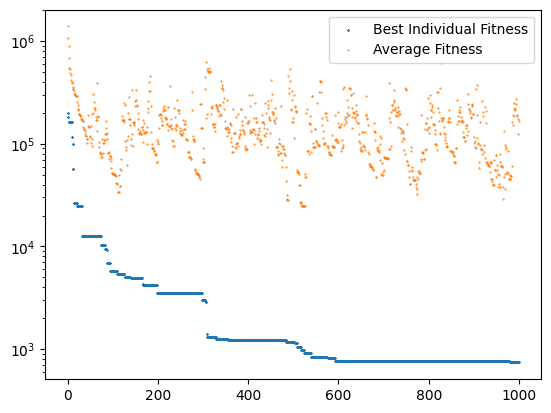

In [17]:
def schwefel_1_2(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sum(np.apply_along_axis(lambda y: y, 0, (x[:i+1]) - 10)) ** 2
    return cost

for i in range(30):
    np.random.seed(i)
    metric_schwefel_1_2 = MetricCollector(name="schwefel_1_2", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.1 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=schwefel_1_2,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_schwefel_1_2,
    )
    metric_schwefel_1_2.save_results()
metric_schwefel_1_2.compile_graph()
res

iter: 0, best: 12144.43053175487, avg: 12569.743887036797
iter: 100, best: 10848.331762455953, avg: 11325.216354750726
iter: 200, best: 10730.803279362366, avg: 11086.507222481705
iter: 300, best: 10677.094489369254, avg: 10985.661409464412
iter: 400, best: 10664.900682043955, avg: 10997.9566224193
iter: 500, best: 10660.508788599966, avg: 10801.546466122
iter: 600, best: 10660.478196600247, avg: 10877.713211036293
iter: 700, best: 10660.478196600247, avg: 10852.24206907487
iter: 800, best: 10660.478196600247, avg: 10950.038944033415
iter: 900, best: 10660.478196600247, avg: 11068.147590951012
iter: 0, best: 12212.72340081983, avg: 12566.983691520452
iter: 100, best: 10914.490185911178, avg: 11010.266318407015
iter: 200, best: 10729.88319303674, avg: 10977.968663302221
iter: 300, best: 10663.050731321298, avg: 11055.868596361086
iter: 400, best: 10661.333882858908, avg: 10973.600440849379
iter: 500, best: 10660.991111365243, avg: 10911.153775445166
iter: 600, best: 10660.755265079884, 

(array([  65.22765784,   66.18351216, -100.        ,   66.21197101,
          66.05253449,   65.47113841,   64.75009463,   66.14493237,
          64.78251729,   65.57553641,   66.08851701, -100.        ,
          65.32472954,   65.32163354,   65.2832879 ,   65.06609594,
          66.09061383,   65.36851554,   65.84555653,   65.93692473,
          65.03257911,   65.34190326,   65.96484971,   65.22760233,
          65.44600718,   65.40219409,   65.36542162,   65.55875899,
          65.84832613,   65.94134171]),
 10679.558151611875)

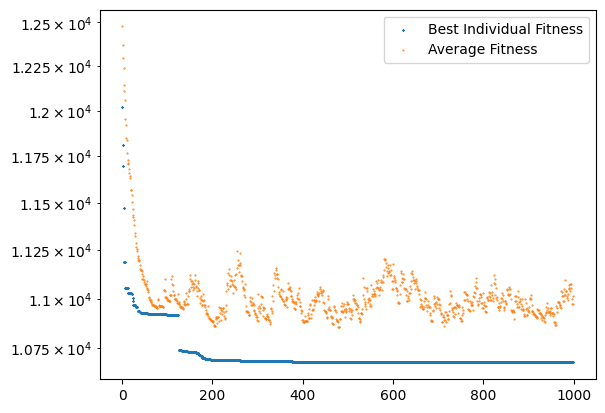

In [18]:
def schwefel_2_3(x: np.ndarray):
    cost = 418.9829 * x.shape[0] - np.sum(np.apply_along_axis(lambda y: y * np.sin(np.sqrt(np.abs(y))), 0, x))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_schwefel_2_3 = MetricCollector(name="schwefel_2_3", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.8 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=schwefel_2_3,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_schwefel_2_3,
        vtr=1
    )
    metric_schwefel_2_3.save_results()
metric_schwefel_2_3.compile_graph()
res

iter: 0, best: 2933536.0767453336, avg: 3631298.7635801905
iter: 100, best: 8.339872717934327, avg: 29.81253774004987
iter: 200, best: 8.621305153155845e-05, avg: 0.006775282421216389
iter: 300, best: 5.614310794044286e-09, avg: 90.91569365794189
iter: 400, best: 1.1264091881457716e-09, avg: 130.3456834861995
iter: 500, best: 1.1264091881457716e-09, avg: 0.006819363276770218
iter: 600, best: 1.1264091881457716e-09, avg: 28.11774948645194
iter: 700, best: 1.6046897144406103e-10, avg: 2.6472431123462514
iter: 800, best: 5.3944404498906806e-11, avg: 15.139664924809603
iter: 900, best: 5.3944404498906806e-11, avg: 6.549597824232479e-05
iter: 0, best: 2476306.113690936, avg: 3578040.467125535
iter: 100, best: 43.02947464375177, avg: 109.74447574504941
iter: 200, best: 0.00024014113330395048, avg: 0.0006549372129484255
iter: 300, best: 2.410388333373703e-09, avg: 31.566442711092684
iter: 400, best: 1.1795009413617663e-10, avg: 60.15631390009037
iter: 500, best: 1.1795009413617663e-10, avg: 0

(array([ 1.76080321e-07,  1.24572431e-07,  8.80798568e-08, -1.56808434e-07,
         1.37456674e-07,  2.48456088e-06,  6.16942265e-08, -2.94532589e-08,
         5.83240823e-07,  8.07715451e-07,  2.51819640e-07, -2.06268642e-07,
        -1.58035234e-06,  1.96599125e-07,  2.14846703e-08,  2.59500606e-07,
        -3.16663743e-07,  1.10107733e-06,  1.46055891e-07,  2.78081341e-07,
        -3.89812900e-08,  2.66162223e-07, -1.82596420e-06,  1.17498074e-06,
         1.64459274e-07,  2.59949273e-07, -2.47756258e-07, -1.66498064e-06,
        -4.14728238e-07,  1.62562515e-07]),
 6.252776074688882e-13)

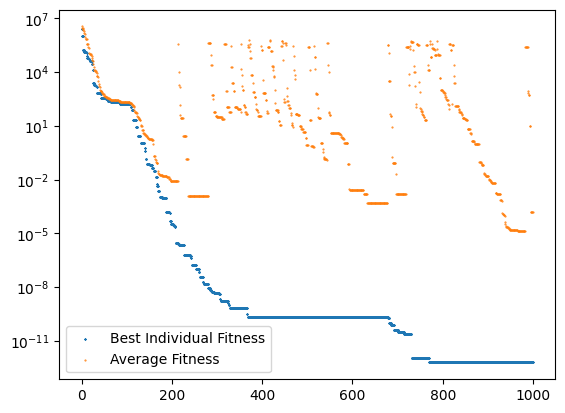

In [19]:
def rastrigin(x: np.ndarray):
    return 10 * x.shape[0] + np.sum(np.apply_along_axis(lambda y: y**2 - 10 * np.cos(2 * np.pi * y), 0, x))

for i in range(30):
    np.random.seed(i)
    metric_rastrigin = MetricCollector(name="rastrigin", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.1 * (i / n_iters)
    popsize=10
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=rastrigin,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_rastrigin,
    )
    metric_rastrigin.save_results()

metric_rastrigin.compile_graph()
res

iter: 0, best: 1.0, avg: 1.0
iter: 100, best: 0.05329046012967409, avg: 0.9125266923857209
iter: 200, best: 0.006077491725302142, avg: 0.8639491556865424
iter: 300, best: 0.00014310510585124891, avg: 0.7766850932095117
iter: 400, best: 0.00014310510585124891, avg: 0.8722272938200544
iter: 500, best: 0.00013722152653028452, avg: 0.7454728867872941
iter: 600, best: 3.773436996379331e-05, avg: 0.6756966854506621
iter: 700, best: 3.773436996379331e-05, avg: 0.7342189539396562
iter: 800, best: 1.2683964633053435e-06, avg: 0.7619653308519172
iter: 900, best: 1.2683964633053435e-06, avg: 0.7729172211365455
iter: 0, best: 1.0, avg: 1.0
iter: 100, best: 0.001029753758857388, avg: 0.7813688850270353
iter: 200, best: 0.0001820091804232149, avg: 0.5300637472435378
iter: 300, best: 2.080113980729159e-05, avg: 0.6912551134616096
iter: 400, best: 2.080113980729159e-05, avg: 0.6815778412964792
iter: 500, best: 2.080113980729159e-05, avg: 0.6701745209825073
iter: 600, best: 1.0572871384395555e-05, avg:

(array([3.0782977 , 3.16878023]), 2.8515483416313714e-05)

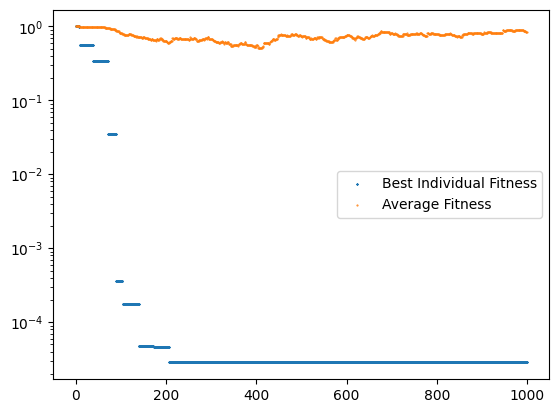

In [20]:
for i in range(30):
    easom = lambda x: bf.Easom()(x) + 1
    np.random.seed(i)
    metric_easom = MetricCollector(name="easom", run_id=i)
    d = 2
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.8 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=easom,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_easom,
    )
    metric_easom.save_results()
metric_easom.compile_graph()
res

iter: 0, best: 1068016.834333889, avg: 1553641.3431595906
iter: 100, best: 0.062190865452686164, avg: 0.4777212287517593
iter: 200, best: 4.330807084090711e-08, avg: 3.547452857079852e-05
iter: 300, best: 1.2985853095294645e-14, avg: 0.026779571899023174
iter: 400, best: 1.621119936572172e-17, avg: 101420.18266891003
iter: 500, best: 1.621119936572172e-17, avg: 41195.50317331444
iter: 600, best: 1.621119936572172e-17, avg: 21.43947593894019
iter: 700, best: 1.621119936572172e-17, avg: 1257.8452887284807
iter: 800, best: 1.621119936572172e-17, avg: 33083.0518688623
iter: 900, best: 1.621119936572172e-17, avg: 3121.780515153162
iter: 0, best: 951244.875073149, avg: 1550071.3769005009
iter: 100, best: 0.09922023401120415, avg: 6.0481837025917216
iter: 200, best: 2.604055464560587e-08, avg: 0.00010674916947510061
iter: 300, best: 4.701882090820886e-13, avg: 0.1137455993946038
iter: 400, best: 8.357600441423353e-16, avg: 31.076007751023372
iter: 500, best: 8.357600441423353e-16, avg: 66936.

(array([-7.12775944e-07, -1.35647714e-06, -1.10488168e-06,  6.12147593e-07,
         2.59012150e-06,  2.41290777e-06, -2.20059804e-06,  3.74597878e-06,
        -1.84746267e-06, -1.64258756e-06, -6.11256715e-07, -6.99383749e-07,
        -4.60424196e-06, -7.48330690e-07,  3.84339370e-07, -5.79375728e-06,
         2.75903467e-06,  1.66866199e-06,  2.79593034e-06,  1.61436571e-06,
        -1.30296175e-06,  5.95740718e-06, -1.09884448e-06, -1.84363815e-06,
         1.79143463e-06,  2.95893308e-06,  4.20046938e-06, -3.08005583e-06,
        -3.33045719e-06, -8.22830848e-07]),
 7.524573350868575e-17)

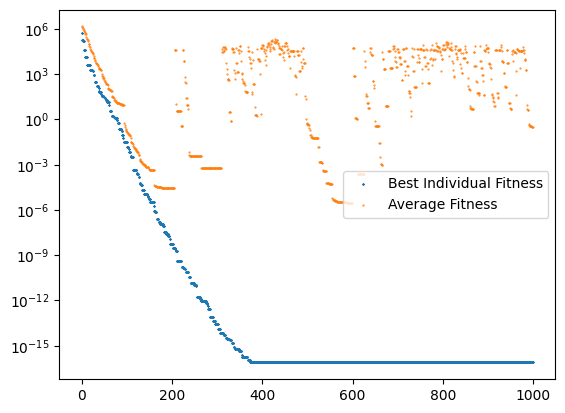

In [21]:
def rotated_hyper_ellipsoid(x: np.ndarray):
    # rotated hyper ellipsoid
    cost = 0
    for i in range(x.shape[0]):
        cost += np.sum(np.apply_along_axis(lambda y: (y)**2, 0, x[:i+1]))
    return cost

for i in range(30):
    np.random.seed(i)
    metric_rotated_hyper_ellipsoid = MetricCollector(name="rotated_hyper_ellipsoid", run_id=i)
    d = 30
    bounds = [(-100, 100) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.8 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=rotated_hyper_ellipsoid,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_rotated_hyper_ellipsoid,
    )
    metric_rotated_hyper_ellipsoid.save_results()
metric_rotated_hyper_ellipsoid.compile_graph()
res

iter: 0, best: 7400.86336825752, avg: 14581.240396743819
iter: 100, best: 28.90846075740672, avg: 885.0303486593615
iter: 200, best: 28.813128356259675, avg: 830.1487669304564
iter: 300, best: 28.786000408568523, avg: 1109.0522106179694
iter: 400, best: 28.74443549461512, avg: 1868.3645044530451
iter: 500, best: 28.74443549461512, avg: 1496.4177120535362
iter: 600, best: 28.74443549461512, avg: 2135.0085216587786
iter: 700, best: 28.61645565671912, avg: 1667.1421994292516
iter: 800, best: 28.61645565671912, avg: 1370.5656718947382
iter: 900, best: 28.61645565671912, avg: 593.5222094565779
iter: 0, best: 6562.2636998072885, avg: 14581.888579600596
iter: 100, best: 28.861274549116263, avg: 1919.0630215346434
iter: 200, best: 28.768187181317128, avg: 1121.279067847607
iter: 300, best: 28.62771952208174, avg: 1228.8837974607843
iter: 400, best: 28.588404786276552, avg: 2093.5611087577017
iter: 500, best: 28.588404786276552, avg: 1039.5993816114683
iter: 600, best: 28.588404786276552, avg: 

(array([-0.03080029,  0.0997788 ,  0.00241357, -0.0124047 ,  0.00300195,
        -0.00038865,  0.13427006, -0.00143911, -0.00169537, -0.03231579,
        -0.01204508, -0.00494376, -0.01359843, -0.03042342, -0.00744343,
         0.01450333, -0.01234927, -0.02523158, -0.00525937, -0.00893851,
         0.00793749, -0.02113704, -0.0100115 ,  0.00162085,  0.00155815,
         0.11105337,  0.00134801, -0.03213202, -0.00670116, -0.0891785 ]),
 28.146763432552074)

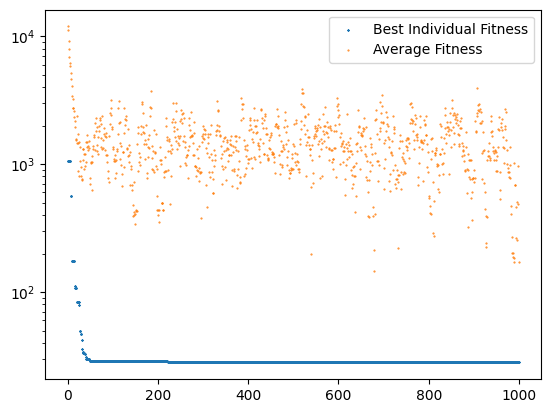

In [22]:
def rosenbrock(x: np.ndarray):
    # rosenbrock
    cost = 0
    for i in range(x.shape[0] - 1):
        cost += 100 * (x[i + 1] - x[i]**2)**2 + (x[i] - 1)**2
    return cost

for i in range(30):
    np.random.seed(i)
    metric_rosen = MetricCollector(name="rosenbrock", run_id=i)
    d = 30
    bounds = [(-2.048, 2.048) for _ in range(30)]
    n_iters = 1000
    J = 0.1
    S = 0.5
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=rosenbrock,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_rosen,
    )
    metric_rosen.save_results()
metric_rosen.compile_graph()
res

iter: 0, best: 591.9422542313703, avg: 902.2839882764532
iter: 100, best: 0.0045629312469877, avg: 0.09422345310518676
iter: 200, best: 5.720471651926573e-09, avg: 3.482461843002382e-05
iter: 300, best: 1.5765166949677223e-14, avg: 0.004550030478195027
iter: 400, best: 0.0, avg: 123.51056369783544
iter: 500, best: 0.0, avg: 0.023775916519809225
iter: 600, best: 0.0, avg: 7.103138755654159e-07
iter: 700, best: 0.0, avg: 0.7533897321084266
iter: 800, best: 0.0, avg: 0.15157672790944918
iter: 900, best: 0.0, avg: 3.372622705777317e-07
iter: 0, best: 545.103040961611, avg: 900.1757760290582
iter: 100, best: 0.001592725258118155, avg: 0.021926952707855125
iter: 200, best: 7.670131196846341e-10, avg: 2.0206323160798513e-07
iter: 300, best: 4.218847493575595e-15, avg: 0.0008314788637122262
iter: 400, best: 0.0, avg: 97.77397568283698
iter: 500, best: 0.0, avg: 0.006244175782988265
iter: 600, best: 0.0, avg: 0.010205572733153211
iter: 700, best: 0.0, avg: 7.49320274939791e-08
iter: 800, best: 

(array([ 1.67410092e-07, -7.80769132e-08, -2.47153751e-07, -6.17930895e-08,
         3.27067181e-07, -3.11071478e-07,  1.00141903e-07,  1.63694761e-06,
         1.33615909e-08,  8.02005663e-07,  1.64007580e-07, -1.01641921e-06,
         7.63351806e-07,  6.04324599e-07, -2.81606220e-07,  3.41507550e-07,
         4.34362502e-07, -6.66541008e-07,  1.27952670e-06,  2.49692327e-06,
         5.44248193e-07, -1.64520682e-06, -3.78502376e-07, -7.67572860e-07,
        -1.26329232e-06,  6.57483143e-07, -2.67777508e-07, -4.34298880e-07,
        -6.33649664e-07,  1.67565492e-06]),
 0.0)

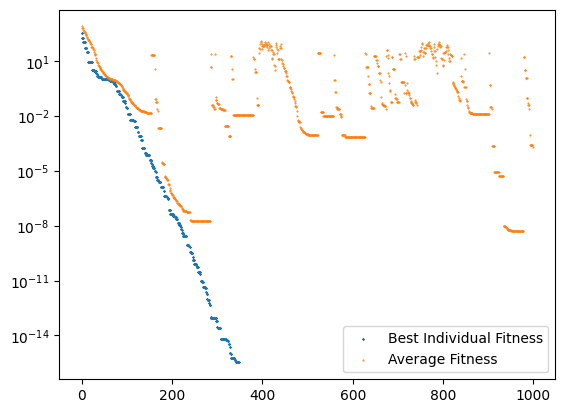

In [23]:
def griewangk(x: np.ndarray):
    cost = 1/4000 * np.sum(np.apply_along_axis(lambda y: y**2, 0, x))
    prod = 1
    for i in range(x.shape[0]):
        prod *= np.cos(x[i] / np.sqrt(i + 1))
    return cost - prod + 1

for i in range(30):
    np.random.seed(i)
    metric_griewangk = MetricCollector(name="griewangk", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=griewangk,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_griewangk,
    )
    metric_griewangk.save_results()
metric_griewangk.compile_graph()
res

iter: 0, best: 1.1535730904427648, avg: 3.031462198845349
iter: 100, best: 5.048350051852604e-09, avg: 5.2000162628124146e-05
iter: 200, best: 7.308248565263046e-14, avg: 0.08037312950773476
iter: 300, best: 8.354289442920547e-18, avg: 0.28090950196026654
iter: 400, best: 8.354289442920547e-18, avg: 0.02564028810445019
iter: 500, best: 8.354289442920547e-18, avg: 1.2653980811638208e-05
iter: 600, best: 8.354289442920547e-18, avg: 0.0775675848893883
iter: 700, best: 8.354289442920547e-18, avg: 0.036083926675252675
iter: 800, best: 8.354289442920547e-18, avg: 0.00011131817668137628
iter: 900, best: 8.354289442920547e-18, avg: 0.1942323730119757
iter: 0, best: 1.3966183130881922, avg: 3.0352550346912786
iter: 100, best: 1.7382320156761373e-08, avg: 0.06383497093530363
iter: 200, best: 1.4825563124929807e-13, avg: 6.080012968014836e-07
iter: 300, best: 9.38555878316596e-18, avg: 0.1077414258559283
iter: 400, best: 9.38555878316596e-18, avg: 0.10590236502136818
iter: 500, best: 9.3855587831

(array([-0.107364  ,  0.49664994,  0.05496295, -0.56650138, -0.50269357,
        -0.43551336, -0.31356272,  0.77459557,  0.63762267,  0.7016423 ,
         0.22918416, -0.8698628 ,  0.16702487, -0.18770307, -0.67021516,
        -0.67561216, -0.68891027, -0.15336198, -0.34394417, -0.05029397,
        -0.46605712,  0.09932026, -0.63623109,  0.46610033,  0.33858948,
         0.36902501,  0.61982551, -0.71114306,  0.27060954, -0.6019734 ]),
 1.1451165739849059e-17)

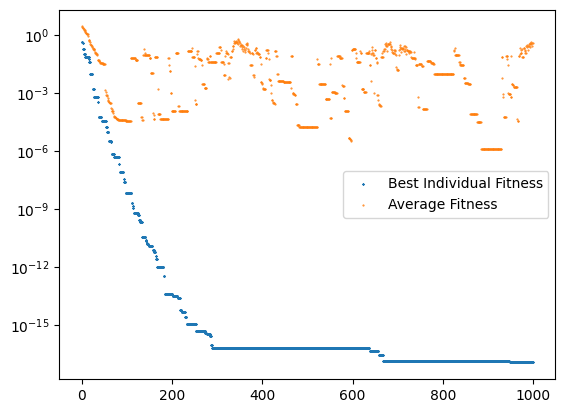

In [126]:
def pow_sum(x: np.ndarray):
    cost = 0
    for i in range(x.shape[0]):
        cost += np.abs(x[i]) ** (i + 1)
    return cost

for i in range(30):
    np.random.seed(i)
    metric_pow_sum = MetricCollector(name="pow_sum", run_id=i)
    d = 30
    bounds = [(-1, 1) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=pow_sum,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_pow_sum,
    )
    metric_pow_sum.save_results()
metric_pow_sum.compile_graph()
res

iter: 0, best: 20.739353060582147, avg: 21.266894214223782
iter: 100, best: 0.0267172803105713, avg: 0.07776375947004244
iter: 200, best: 2.3414013533784583e-05, avg: 0.00037108706488258035
iter: 300, best: 1.7986583289442137e-07, avg: 0.00037501913998445603
iter: 400, best: 1.5225123384254857e-09, avg: 0.05628133922916305
iter: 500, best: 1.7012213859857184e-10, avg: 2.4092166662976147
iter: 600, best: 1.7012213859857184e-10, avg: 0.001962340649601746
iter: 700, best: 1.7012213859857184e-10, avg: 0.00018974019776836216
iter: 800, best: 1.7012213859857184e-10, avg: 0.6320650930175326
iter: 900, best: 1.7012213859857184e-10, avg: 1.342565905996219
iter: 0, best: 20.340094888263476, avg: 21.214140267951542
iter: 100, best: 0.0159418431442373, avg: 0.06427143995589191
iter: 200, best: 2.5394349585372566e-05, avg: 0.0003167885167035145
iter: 300, best: 3.831661432585065e-08, avg: 0.4410635668256038
iter: 400, best: 5.723994611628314e-10, avg: 0.3583580644976088
iter: 500, best: 4.033084977

(array([-0.38396691,  1.84893707,  0.26378007, -2.59399053,  0.28822025,
         0.35413029, -1.23757611,  0.25526235,  0.25175129, -0.17830746,
        -0.04310827,  0.16559412, -0.88909548, -1.35771611, -0.4912336 ,
         0.4788198 ,  0.25647578,  0.20030932,  0.08694633,  0.33467393,
         0.41940505, -0.38048002,  3.15602923,  0.65924188, -0.02569187,
        -0.10647467,  0.04052066,  0.10494292,  0.18805569, 11.19311947]),
 1.7270629371068935e-12)

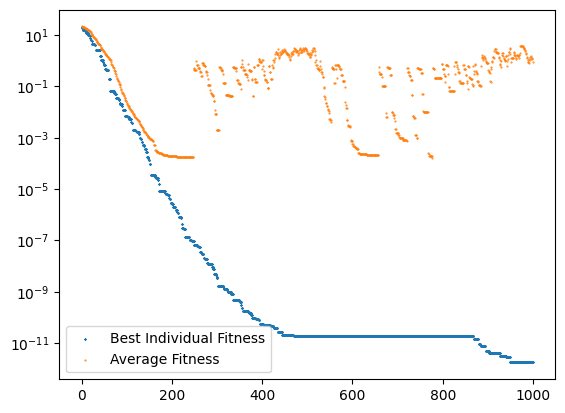

In [127]:
def ackley(x: np.ndarray):
    # ackley function
    cost = -20 * np.exp(-0.2 * np.sqrt(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: y**2, 0, x)))) - np.exp(1/x.shape[0] * np.sum(np.apply_along_axis(lambda y: np.cos(2 * np.pi * y), 0, x))) + 20 + np.exp(1)
    return cost

for i in range(30):
    np.random.seed(i)
    metric_ackley = MetricCollector(name="ackley", run_id=i)
    d = 30
    bounds = [(-32.768, 32.768) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.3 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=ackley,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_ackley,
    )
    metric_ackley.save_results()
metric_ackley.compile_graph()
res

iter: 0, best: 2364036.723388786, avg: 3605437.806163089
iter: 100, best: 35.32387369883338, avg: 91.06951422268784
iter: 200, best: 3.007787933029249e-05, avg: 0.006769466390704792
iter: 300, best: 2.5409008230781183e-11, avg: 18582.804346601653
iter: 400, best: 0.0, avg: 146072.30246135173
iter: 500, best: 0.0, avg: 2.527929790442195
iter: 600, best: 0.0, avg: 3.8761983589097325e-06
iter: 700, best: 0.0, avg: 0.015299760800145635
iter: 800, best: 0.0, avg: 110702.4643562118
iter: 900, best: 0.0, avg: 0.4710940681225466
iter: 0, best: 2176692.4647638914, avg: 3597001.989807807
iter: 100, best: 156.0861171474578, avg: 232.13961220128562
iter: 200, best: 0.002372429407500931, avg: 0.014311144833000356
iter: 300, best: 2.3966890694282483e-09, avg: 0.000121205915267808
iter: 400, best: 0.0, avg: 73.13066836429472
iter: 500, best: 0.0, avg: 12324.933975736196
iter: 600, best: 0.0, avg: 0.00010378442468805815
iter: 700, best: 0.0, avg: 0.00015028486787969087
iter: 800, best: 0.0, avg: 30490

(array([ 2.65581397e-05,  2.01268922e-05,  6.06683999e-05, -5.77081276e-05,
        -2.02642068e-05,  4.01169574e-05,  2.35523707e-05,  6.20061411e-05,
         5.57456767e-06, -7.53646859e-05,  1.73919792e-05, -8.87615856e-05,
        -2.78564296e-05,  5.40608357e-06,  4.77726605e-05, -6.19741204e-06,
         1.01183105e-05, -9.88619520e-06, -1.73557954e-05,  2.25591192e-05,
        -1.99051173e-05, -9.27829298e-06,  8.77162838e-05,  5.78863192e-05,
         4.96584107e-06,  3.74633664e-05,  1.04608884e-05, -1.56131684e-04,
        -2.53139751e-06, -4.80759169e-05]),
 0.0)

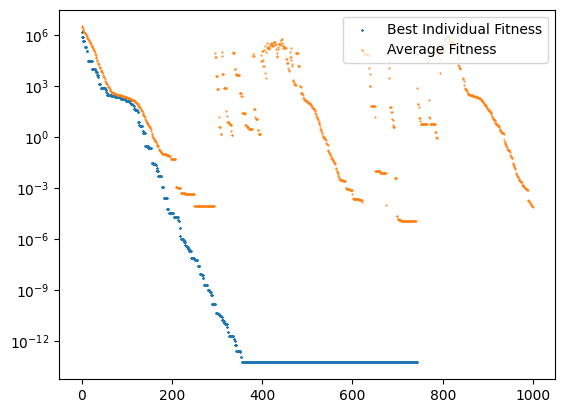

In [128]:
def rastrigin(x: np.ndarray):
    return 10 * x.shape[0] + np.sum(np.apply_along_axis(lambda y: y**2 - 10 * np.cos(2 * np.pi * y), 0, x))

for i in range(30):
    np.random.seed(i)
    metric_rastrigin = MetricCollector(name="rastrigin", run_id=i)
    d = 30
    bounds = [(-600, 600) for _ in range(d)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.1 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=d, seed=i)
    res = gradient_evolution(
        f=rastrigin,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_rastrigin,
    )
    metric_rastrigin.save_results()

metric_rastrigin.compile_graph()
res

iter: 0, best: 33.130643968857505, avg: 456.30780025652587
iter: 100, best: 2.982448974533953, avg: 114.10074145108892
iter: 200, best: 0.9980297774393359, avg: 75.49937739151525
iter: 300, best: 0.9980297774393359, avg: 104.35764595829059
iter: 400, best: 0.9980039716306578, avg: 49.0641051208411
iter: 500, best: 0.9980038379806155, avg: 103.7606439336711
iter: 600, best: 0.9980038379806155, avg: 51.60269664499621
iter: 700, best: 0.9980038379806155, avg: 127.15937946493807
iter: 800, best: 0.9980038379806155, avg: 113.2543065037376
iter: 900, best: 0.9980038379806155, avg: 101.31386799677747
iter: 0, best: 20.434589134221707, avg: 472.6555883934192
iter: 100, best: 2.9821051882619503, avg: 60.345550319174926
iter: 200, best: 1.9921526218599501, avg: 75.6914716059724
iter: 300, best: 1.025379687152281, avg: 81.54566605013073
iter: 400, best: 0.9992684609977945, avg: 120.53526013986257
iter: 500, best: 0.9980041304645878, avg: 75.76168545597791
iter: 600, best: 0.9980038718723295, avg:

(array([-0.32597348, -0.09448396]), 0.9980038425074849)

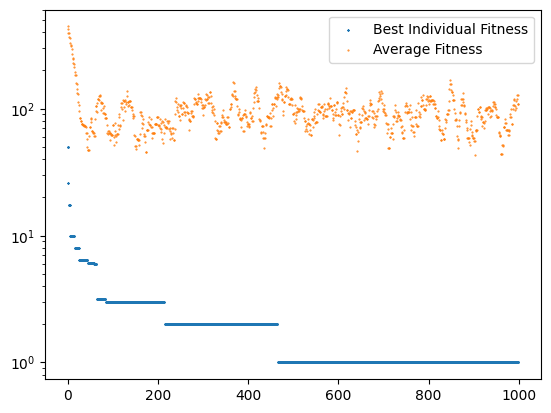

In [137]:
for i in range(30):
    np.random.seed(i)
    metric_dejong_5 = MetricCollector(name="dejong_5", run_id=i)
    funcs = bf.DeJong5()
    bounds = [(-65.536, 65.636), (-65.536, 65.636)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.1 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=2, seed=i)
    res = gradient_evolution(
        f=funcs,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_dejong_5,
        vtr=1
    )
    metric_dejong_5.save_results()
metric_dejong_5.compile_graph()
res

iter: 0, best: 79, avg: 109.225
iter: 100, best: 0, avg: 14.65
iter: 200, best: 0, avg: 8.575
iter: 300, best: 0, avg: 5.4
iter: 400, best: 0, avg: 10.35
iter: 500, best: 0, avg: 5.45
iter: 600, best: 0, avg: 11.4
iter: 700, best: 0, avg: 4.55
iter: 800, best: 0, avg: 7.2
iter: 900, best: 0, avg: 12.225
iter: 0, best: 70, avg: 108.975
iter: 100, best: 0, avg: 16.925
iter: 200, best: 0, avg: 13.35
iter: 300, best: 0, avg: 15.275
iter: 400, best: 0, avg: 17.225
iter: 500, best: 0, avg: 4.875
iter: 600, best: 0, avg: 3.875
iter: 700, best: 0, avg: 12.6
iter: 800, best: 0, avg: 6.525
iter: 900, best: 0, avg: 11.1
iter: 0, best: 84, avg: 109.175
iter: 100, best: 0, avg: 13.75
iter: 200, best: 0, avg: 8.15
iter: 300, best: 0, avg: 11.525
iter: 400, best: 0, avg: 7.5
iter: 500, best: 0, avg: 11.575
iter: 600, best: 0, avg: 18.125
iter: 700, best: 0, avg: 7.575
iter: 800, best: 0, avg: 8.3
iter: 900, best: 0, avg: 8.875
iter: 0, best: 86, avg: 109.175
iter: 100, best: 0, avg: 14.9
iter: 200, b

(array([-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
        -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
        -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5]),
 0)

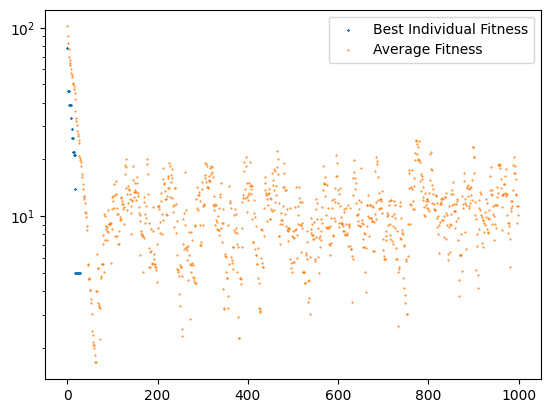

In [131]:
for i in range(30):
    np.random.seed(i)
    dejong_3_func = lambda x: bf.DeJong3(n_dimensions=30)(x) + 120
    metric_dejong_3 = MetricCollector(name="dejong_3", run_id=i)
    dejong_3_stub = lambda x: dejong_3_func(x)
    bounds = [(-3.5, 3.8) for i in range(30)]
    n_iters = 1000
    J = 0.5
    S = 0.1
    ep = 0.05
    gamma = lambda i: 0.5 * (1 - i / n_iters) + 0.1 * (i / n_iters)
    popsize=40
    sampler = stats.qmc.LatinHypercube(d=30, seed=i)
    res = gradient_evolution(
        f=dejong_3_stub,
        pop_initializer=lambda x: latin(sampler, x, bounds),
        popsize=popsize,
        n_iter=n_iters,
        gamma=gamma,
        J=J,
        S=S,
        ep=ep,
        bounds=bounds,
        metric_collector=metric_dejong_3,
    )
    metric_dejong_3.save_results()
metric_dejong_3.compile_graph()
res